In [1]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def MMD(x, y, kernel):
    """Emprical maximum mean discrepancy. The lower the result
       the more evidence that distributions are the same.

    Args:
        x: first sample, distribution P
        y: second sample, distribution Q
        kernel: kernel type such as "multiscale" or "rbf"
    """
    xx, yy, zz = torch.mm(x, x.t()), torch.mm(y, y.t()), torch.mm(x, y.t())
    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))

    dxx = rx.t() + rx - 2. * xx # Used for A in (1)
    dyy = ry.t() + ry - 2. * yy # Used for B in (1)
    dxy = rx.t() + ry - 2. * zz # Used for C in (1)

    XX, YY, XY = (torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device))

    if kernel == "multiscale":

        bandwidth_range = [0.2, 0.5, 0.9, 1.3]
        for a in bandwidth_range:
            XX += a**2 * (a**2 + dxx)**-1
            YY += a**2 * (a**2 + dyy)**-1
            XY += a**2 * (a**2 + dxy)**-1

    if kernel == "rbf":

        bandwidth_range = [10, 15, 20, 50]
        for a in bandwidth_range:
            XX += torch.exp(-0.5*dxx/a)
            YY += torch.exp(-0.5*dyy/a)
            XY += torch.exp(-0.5*dxy/a)



    return torch.mean(XX + YY - 2. * XY)

In [20]:
n = 1000
shape = (n, 1)
x = torch.randn(*shape, device=device) + 100
y = torch.randn(*shape, device=device)

MMD(x, y, "multiscale")

tensor(3.2664)

In [6]:
y

tensor([[-0.3366, -0.0248],
        [-0.2395,  1.2967],
        [-0.3508, -1.7608],
        [-0.5652,  0.3536],
        [-1.3200,  1.0945],
        [-0.1719,  0.4574],
        [-0.8441,  1.1226],
        [-0.4618,  0.0602],
        [-1.1489,  2.2684],
        [ 2.3621, -2.1875],
        [-0.7555,  0.8472],
        [ 0.4164,  0.3804],
        [-1.2010,  0.1721],
        [ 0.5321, -1.1577],
        [-2.2462,  0.5495],
        [ 0.9428, -0.9436],
        [-0.5089,  3.0139],
        [-1.3694,  1.2250],
        [ 1.6607, -0.4158],
        [-0.0860,  3.2964]])

MMD result of X and Y is 0.5802701711654663


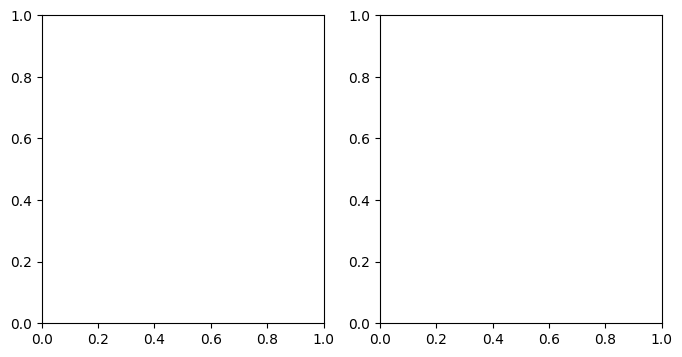

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.stats import dirichlet
from torch.distributions.multivariate_normal import MultivariateNormal


m = 20 # sample size
x_mean = torch.zeros(2)+1
y_mean = torch.zeros(2)
x_cov = 2*torch.eye(2) # IMPORTANT: Covariance matrices must be positive definite
y_cov = 3*torch.eye(2) - 1

px = MultivariateNormal(x_mean, x_cov)
qy = MultivariateNormal(y_mean, y_cov)
x = px.sample([m]).to(device)
y = qy.sample([m]).to(device)

result = MMD(x, y, kernel="multiscale")

print(f"MMD result of X and Y is {result.item()}")

# ---- Plotting setup ----

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,4), dpi=100)
#plt.tight_layout()
delta = 0.025

x1_val = np.linspace(-5, 5, num=m)
x2_val = np.linspace(-5, 5, num=m)

x1, x2 = np.meshgrid(x1_val, x2_val)

px_grid = torch.zeros(m,m)
qy_grid = torch.zeros(m,m)


for i in range(m):
    for j in range(m):
        px_grid[i,j] = multivariate_normal.pdf([x1_val[i],x2_val[j]], x_mean, x_cov)
        qy_grid[i,j] = multivariate_normal.pdf([x1_val[i],x2_val[j]], y_mean, y_cov)


# CS1 = ax1.contourf(x1, x2, px_grid,100, cmap=plt.cm.YlGnBu)
# ax1.set_title("Distribution of $$X \sim P(X)$$")
# ax1.set_ylabel('$$x_2$$')
# ax1.set_xlabel('$$x_1$$')
# ax1.set_aspect('equal')
# ax1.scatter(x[:10,0].cpu(), x[:10,1].cpu(), label="$$X$$ Samples", marker="o", facecolor="r", edgecolor="k")
# ax1.legend()

# CS2 = ax2.contourf(x1, x2, qy_grid,100, cmap=plt.cm.YlGnBu)
# ax2.set_title("Distribution of $$Y \sim Q(Y)$$")
# ax2.set_xlabel('$$y_1$$')
# ax2.set_ylabel('$$y_2$$')
# ax2.set_aspect('equal')
# ax2.scatter(y[:10,0].cpu(), y[:10,1].cpu(), label="$$Y$$ Samples", marker="o", facecolor="r", edgecolor="k")
# ax2.legend()
# #ax1.axis([-2.5, 2.5, -2.5, 2.5])

# # Add colorbar and title
# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
# cbar = fig.colorbar(CS2, cax=cbar_ax)
# cbar.ax.set_ylabel('Density results')
# plt.suptitle(f"MMD result: {round(result.item(),3)}",y=0.95, fontweight="bold")
# plt.show()